In [1]:
from model_mask import *
from VGAE import *


import torch
from torch_geometric.utils import to_dense_adj, to_dense_batch
from baseline import Baseline
import networkx as nx
from metrics import *
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
# seed all randomness
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
NUMBER_OF_SAMPLES = 1000

In [4]:
def remove_isolated_nodes(graphs):
    for graph in graphs:
        graph.remove_nodes_from(list(nx.isolates(graph)))

In [5]:
from datamodule import TUDataMoudle


datamodule = TUDataMoudle()
datamodule.setup("fit")
training_batch = next(iter(datamodule.train_dataloader())) 
adjesency_matrixes = to_dense_adj(training_batch.edge_index, training_batch.batch)
training_samples = [nx.from_numpy_array(adjesency_matrix.detach().numpy()) for adjesency_matrix in adjesency_matrixes]

remove_isolated_nodes(training_samples)

In [6]:
VAE_graph_model = VAE.load_from_checkpoint("graph_VAE.ckpt")
VAE_node_model = VGAE.load_from_checkpoint("node_VAE.ckpt")

baseline = Baseline(training_samples)

/home/ubuntu/miniconda3/envs/advanceML/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'prior' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['prior'])`.
/home/ubuntu/miniconda3/envs/advanceML/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'decoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['decoder'])`.
/home/ubuntu/miniconda3/envs/advanceML/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.


In [7]:
VAE_graph_samples = [nx.from_numpy_array(adjesency_matrix.cpu().detach().numpy()) for adjesency_matrix in VAE_graph_model.sample(NUMBER_OF_SAMPLES)]
VAE_graph_samples = [
    nx.Graph(graph.subgraph(range(nodes_number)))
    for graph, nodes_number in zip(VAE_graph_samples, np.random.choice(baseline.node_number_distribution, len(VAE_graph_samples), replace=True))
]


VAE_node_samples = [nx.from_numpy_array(adjesency_matrix.cpu().detach().numpy()) for adjesency_matrix in VAE_node_model.sample(NUMBER_OF_SAMPLES)]
VAE_node_samples = [
    nx.Graph(graph.subgraph(range(nodes_number)))
    for graph, nodes_number in zip(VAE_node_samples, np.random.choice(baseline.node_number_distribution, len(VAE_node_samples), replace=True))
]
# remove_isolated_nodes(generated_samples)

baseline_samples = baseline.sample(NUMBER_OF_SAMPLES)
# remove_isolated_nodes(baseline_samples)

In [8]:
def plot_histogram(training_samples, baseline_samples, generated_samples, title, histogram_function, bins=10):
    training_data, baseline_data, generated_data = histogram_function(training_samples), histogram_function(baseline_samples), histogram_function(generated_samples)
   
    # Increase the width of the figure
    plt.figure(figsize=(20, 5))  
    plt.suptitle(title, fontsize=16)

    # Create the first subplot and specify it to share its y-axis
    ax1 = plt.subplot(1, 3, 1)
    plt.hist(training_data, weights=[1/len(training_samples)]*len(training_data), bins=bins)
    plt.title("Training data", fontsize=12)
    
    # Create the second subplot, sharing the y-axis with the first subplot
    ax2 = plt.subplot(1, 3, 2, sharey=ax1)
    plt.hist(baseline_data, weights=[1/len(baseline_samples)]*len(baseline_data), bins=bins)
    plt.title("Baseline data", fontsize=12)
    plt.setp(ax2.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis

    # Create the third subplot, sharing the y-axis with the first subplot
    ax3 = plt.subplot(1, 3, 3, sharey=ax1)
    plt.hist(generated_data, weights=[1/len(generated_samples)]*len(generated_data), bins=bins)
    plt.title("Generated data", fontsize=12)
    plt.setp(ax3.get_yticklabels(), visible=False)  # Optionally hide y-axis labels for shared axis
    
    # Apply tight layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Show the plot


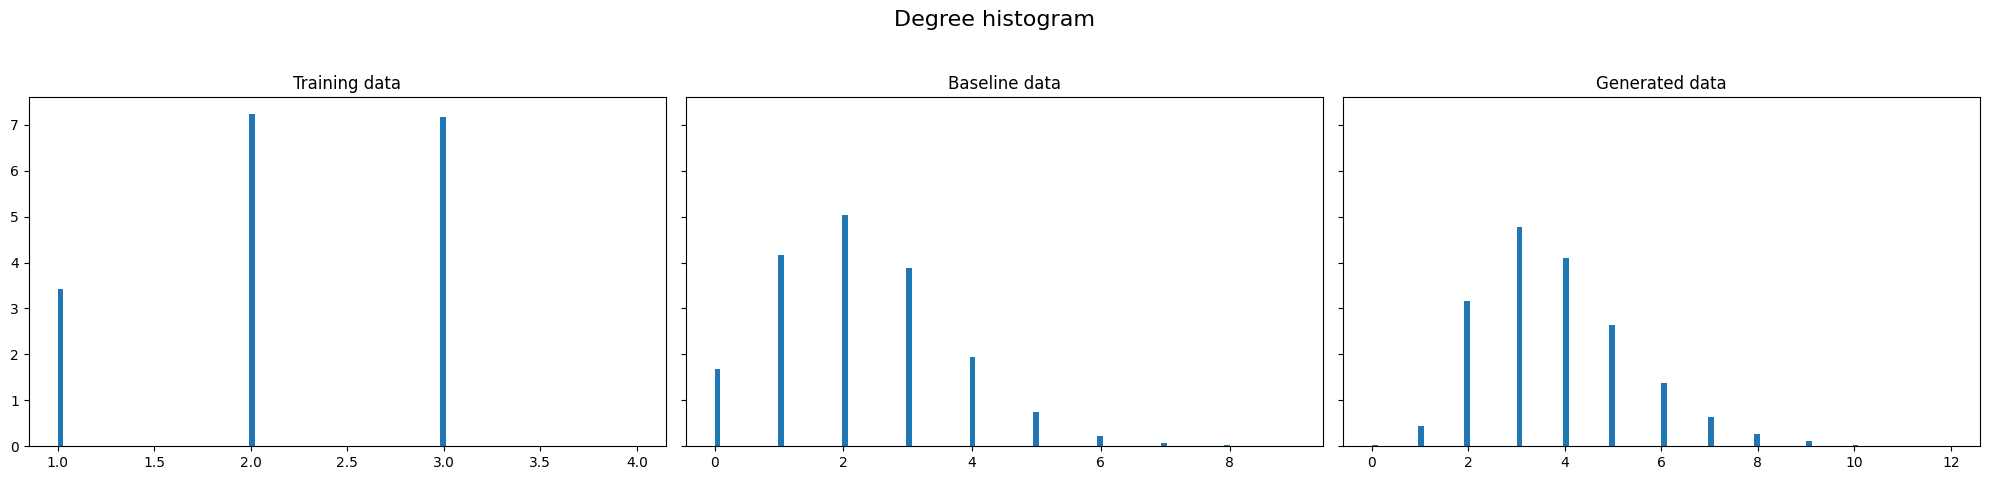

In [9]:
plot_histogram(training_samples, baseline_samples, VAE_graph_samples, "Degree histogram", degree_histogram, 100 )

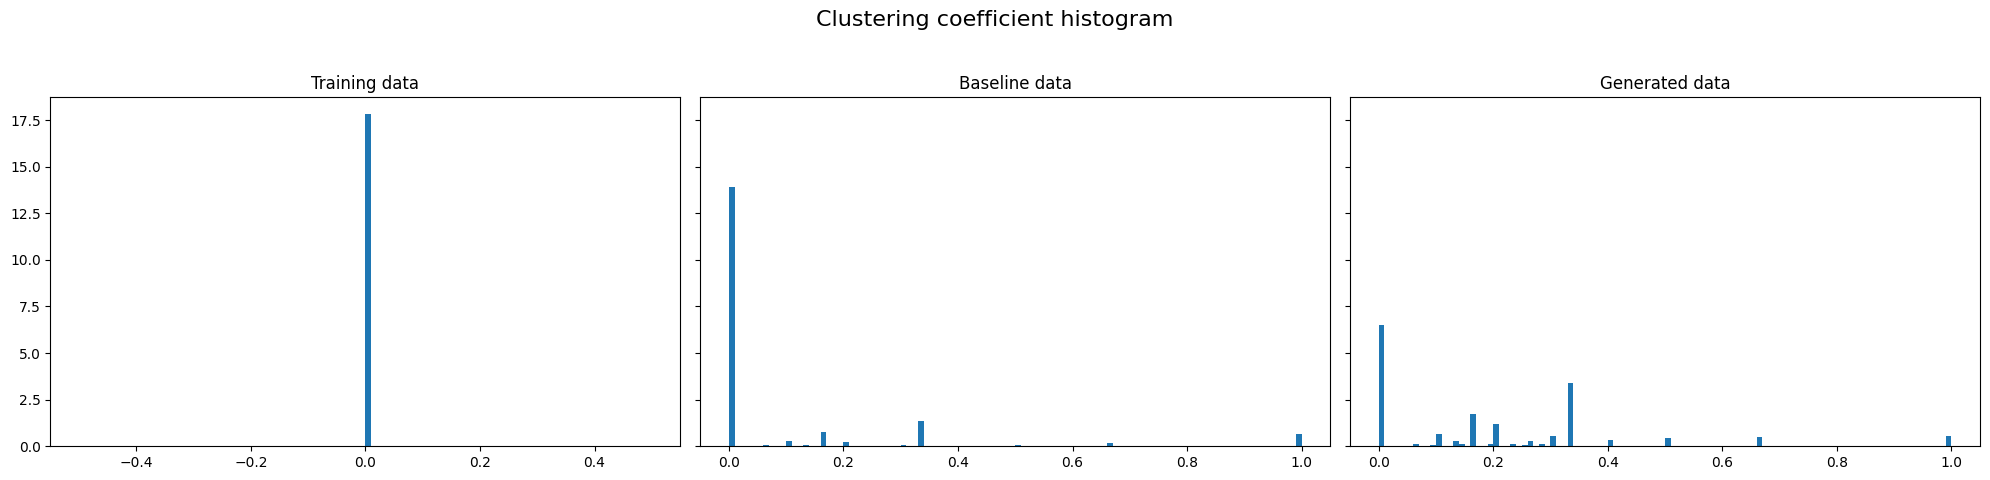

In [10]:
plot_histogram(training_samples, baseline_samples, VAE_graph_samples, "Clustering coefficient histogram", clustering_coefficient_histogram,100 )

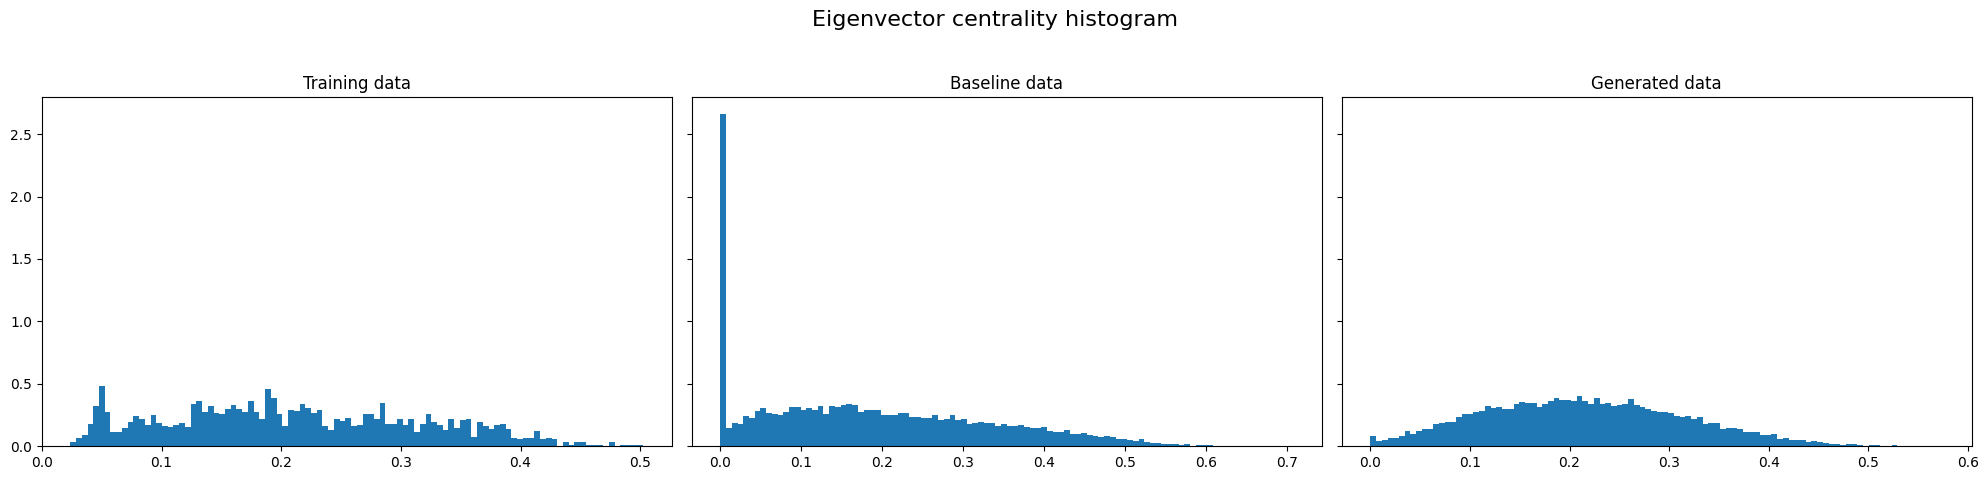

In [11]:
plot_histogram(training_samples, baseline_samples, VAE_graph_samples, "Eigenvector centrality histogram", eigenvector_centrality_histogram, 100 )

In [12]:
VAE_graph_novelty = novel(VAE_graph_samples, training_samples)
VAE_graph__uniqnes = unique(VAE_graph_samples)

print("VAE_graph novelty: ", VAE_graph_novelty)
print("VAE_graph uniqnes: ", VAE_graph__uniqnes)

VEA_node_novelty = novel(VAE_node_samples, training_samples)
VEA_node_uniqnes = unique(VAE_node_samples)

print("VEA_node novelty: ", VEA_node_novelty)
print("VEA_node uniqnes: ", VEA_node_uniqnes)


baseline_novelty = novel(baseline_samples, training_samples)
baseline_uniqnes = unique(baseline_samples)

print("Baseline novelty: ", baseline_novelty)
print("Baseline uniqnes: ", baseline_uniqnes)





VAE_graph novelty:  1.0
VAE_graph uniqnes:  1.0
VEA_node novelty:  1.0
VEA_node uniqnes:  1.0
Baseline novelty:  1.0
Baseline uniqnes:  0.999


In [13]:
# novel_unique_baseline = (baseline_novelty + baseline_uniqnes) / 2
# novel_unique_generated = (generated_novelty + generated_uniqnes) / 2



In [14]:
latex_table = f"""
\\begin{{table}}[H]
\\centering
\\begin{{tabular}}{{lccc}}
\\hline
& Novel & Unique & Novel+unique \\\\
\\hline
Baseline & {baseline_novelty*100}\\% & {baseline_uniqnes*100}\\% & {novel_unique_baseline*100}\\% \\\\
Deep generative model & {generated_novelty*100}\\% & {generated_uniqnes*100}\\% & {novel_unique_generated*100}\\% \\\\
\\hline
\\end{{tabular}}
\\caption{{The percentage of the sampled graphs that are novel and unique.}}
\\label{{table:novel_unique}}
\\end{{table}}
"""

print(latex_table)

NameError: name 'novel_unique_baseline' is not defined

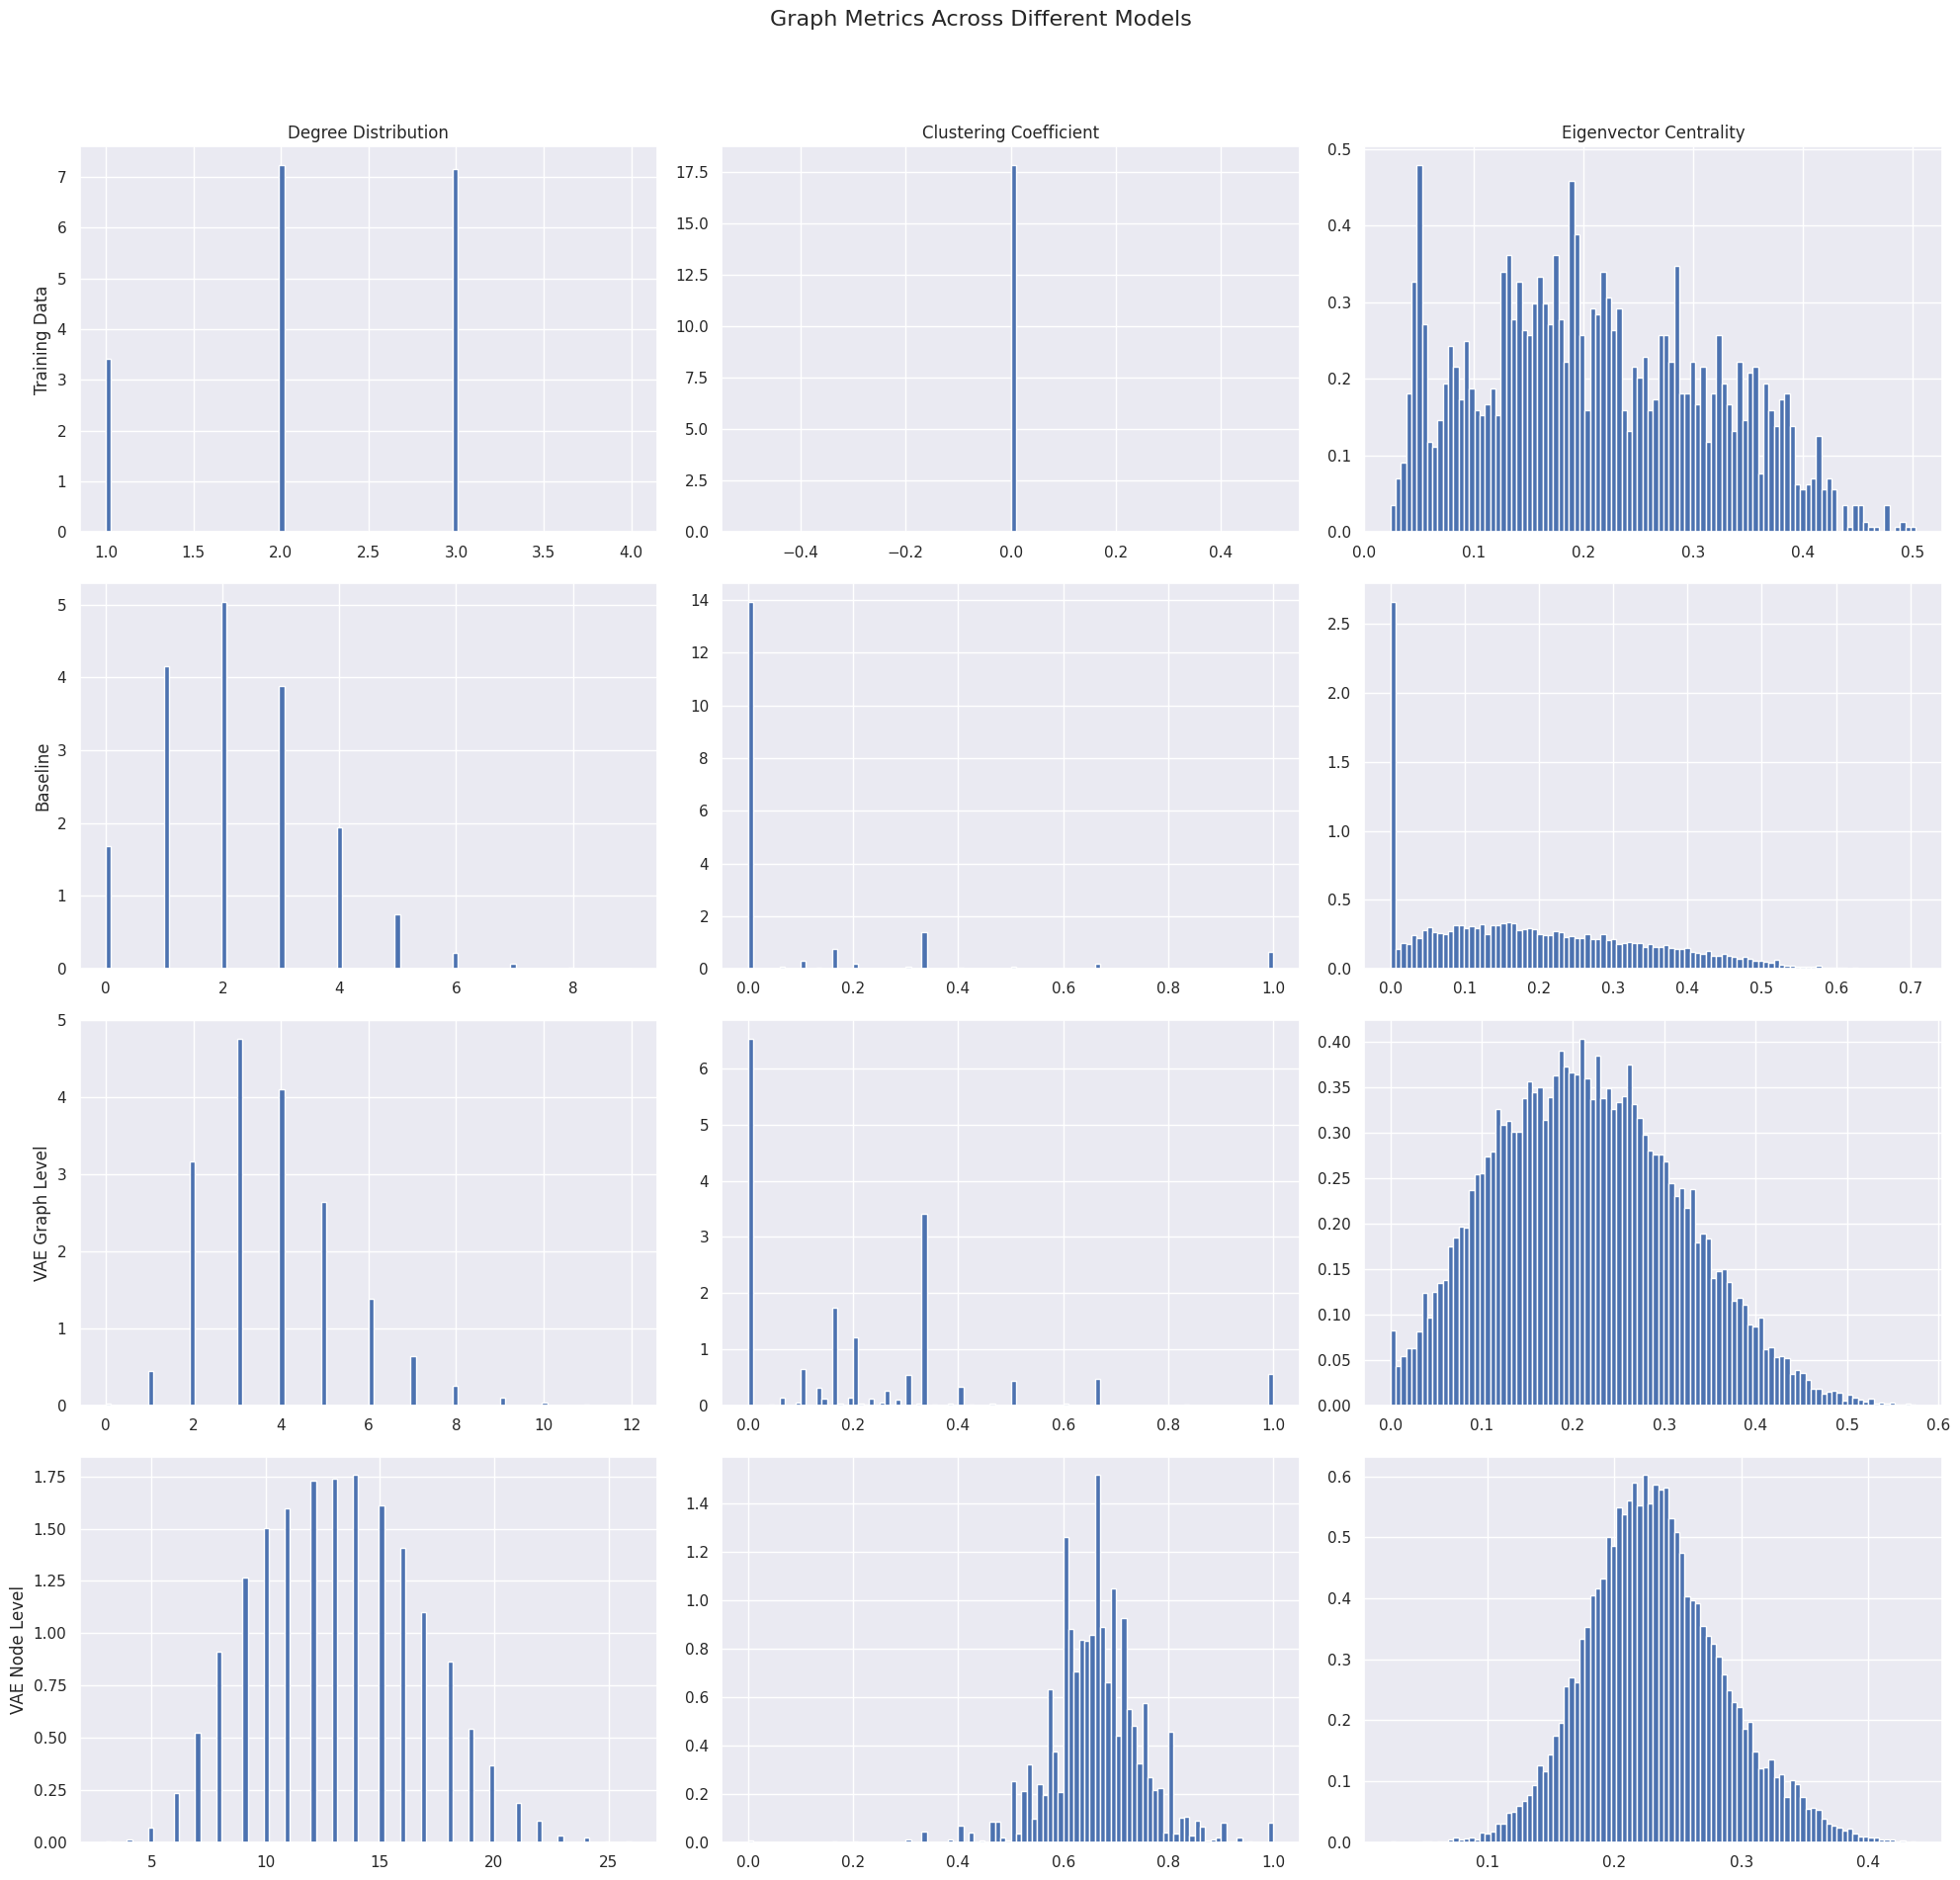

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

def plot_histograms(sample_groups, titles, histogram_functions, bins=10):
    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
    fig.suptitle("Graph Metrics Across Different Models", fontsize=16)

    for i, (row_samples, row_title) in enumerate(zip(sample_groups, ["Training Data", "Baseline", "VAE Graph Level", "VAE Node Level"])):
        for j, (col_title, histogram_function) in enumerate(zip(titles, histogram_functions)):
            data = histogram_function(row_samples)
            axes[i, j].hist(data, weights=[1/len(row_samples)]*len(data), bins=bins)
            if i == 0:
                axes[i, j].set_title(col_title, fontsize=12)
            if j == 0:
                axes[i, j].set_ylabel(row_title, fontsize=12)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Prepare the data grouped by row
sample_groups = [
    training_samples,  # Replace with actual data
    baseline_samples,  # Replace with actual data
    VAE_graph_samples,  # Replace with actual data
    VAE_node_samples   # Replace with actual data
]


# Titles for the columns
titles = ["Degree Distribution", "Clustering Coefficient", "Eigenvector Centrality"]

plot_histograms(sample_groups, titles, [degree_histogram, clustering_coefficient_histogram, eigenvector_centrality_histogram], 100)


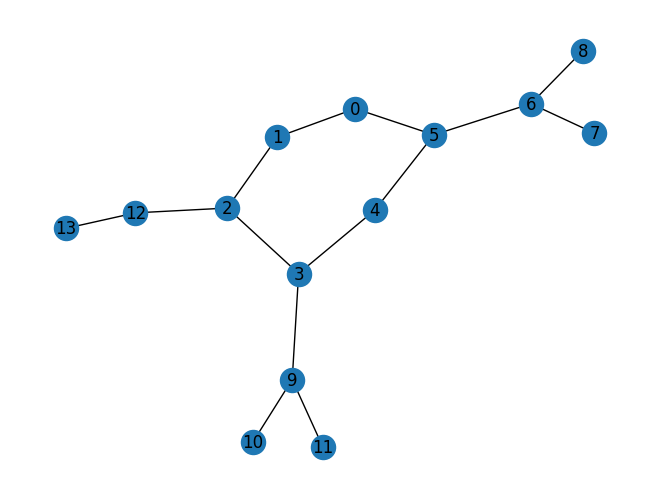

In [ ]:
nx.draw(training_samples[0], with_labels=True)

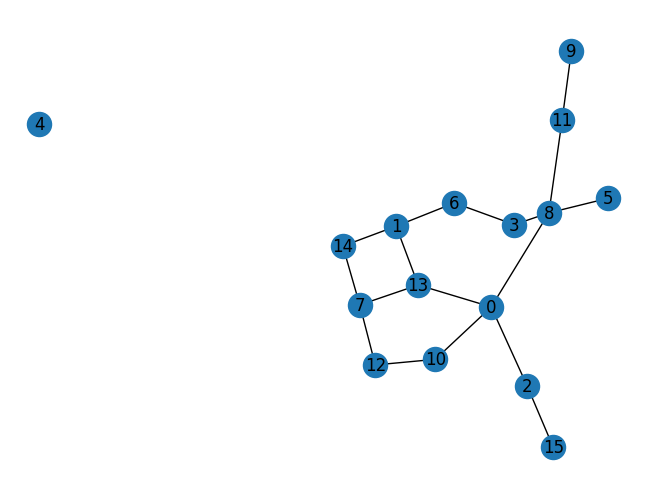

In [ ]:
nx.draw(baseline_samples[0], with_labels=True)

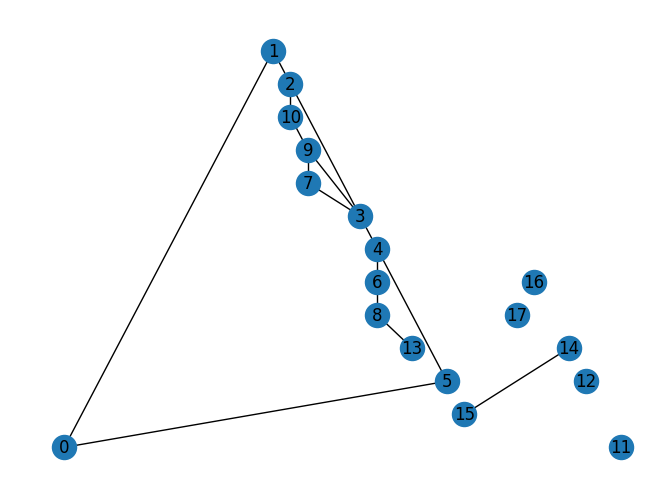

In [ ]:
nx.draw(VAE_graph_samples[0], with_labels=True, pos=nx.planar_layout(VAE_graph_samples[0]))


In [ ]:
from einops import rearrange
prior = GaussianPrior(8)

model.to('cpu')
bernoulli_distribution = model.decoder(prior().sample(torch.tensor([1])))

# Accessing the Bernoulli distribution inside the Independent wrapper
internal_bernoulli = bernoulli_distribution.base_dist

# Accessing logits directly
retrieved_logits = internal_bernoulli.logits

# Converting logits to probabilities
probs = torch.sigmoid(retrieved_logits)
probs = rearrange(probs, 'b (c n) -> b c n', c=28)

print(probs)

result = bernoulli_distribution.sample()
result = rearrange(result, 'b (c n) -> b c n', c=28)

tensor([[[2.2733e-06, 1.0000e+00, 9.3631e-06, 4.8922e-05, 5.6735e-18,
          1.3259e-02, 1.7615e-03, 4.8293e-05, 9.0385e-38, 3.3923e-39,
          1.2689e-06, 2.0700e-30, 1.2300e-37, 0.0000e+00, 8.5137e-06,
          1.3149e-04, 1.8725e-04, 1.0323e-24, 1.6556e-03, 1.2554e-05,
          3.1830e-04, 8.3215e-03, 6.5300e-05, 6.6861e-06, 6.6790e-05,
          2.7154e-05, 2.4793e-05, 1.6403e-04],
         [9.9837e-01, 5.5951e-05, 9.9638e-01, 3.0330e-22, 1.7647e-04,
          4.5180e-04, 0.0000e+00, 1.5394e-04, 4.5556e-06, 0.0000e+00,
          2.6694e-17, 3.8826e-22, 4.2362e-24, 1.4212e-05, 6.7315e-05,
          4.3468e-04, 2.1659e-04, 3.8759e-07, 2.2709e-05, 2.0267e-04,
          1.2229e-06, 1.6532e-05, 5.3299e-06, 3.7721e-04, 5.2878e-05,
          2.9803e-05, 1.5740e-05, 4.2809e-07],
         [1.5805e-05, 9.9978e-01, 3.9168e-05, 1.0000e+00, 2.4703e-05,
          6.3695e-06, 8.3492e-26, 5.6143e-13, 2.6137e-33, 1.0173e-34,
          7.4541e-08, 1.0000e+00, 5.2805e-23, 1.6996e-27, 5.0257e-